In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
oddrationale_mnist_in_csv_path = kagglehub.dataset_download('oddrationale/mnist-in-csv')

print('Data source import complete.')


100%|██████████| 15.2M/15.2M [00:00<00:00, 48.3MB/s]

Extracting files...


Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np

# Assume CSV format: first column 'label' (int), followed by 784 pixel columns (0-255, int)
# Files: 'train.csv' and 'test.csv' in current dir or specify paths
# Normalize pixels to [0,1], reshape to (N, 1, 28, 28) for CNN

def load_mnist_csv(csv_path, has_labels=True):
    df = pd.read_csv(csv_path)
    if has_labels:
        labels = torch.tensor(df['label'].values, dtype=torch.long)
        pixels = df.drop('label', axis=1).values.astype(np.float32) / 255.0
    else:
        labels = None  # For test without labels
        pixels = df.values.astype(np.float32) / 255.0
    images = torch.from_numpy(pixels).unsqueeze(1).view(-1, 1, 28, 28)  # Reshape to (N, 1, 28, 28)
    return images, labels

# Load data (adjust paths if needed, e.g., '/kaggle/input/mnist-csv/train.csv')
train_images, train_labels = load_mnist_csv(f'{oddrationale_mnist_in_csv_path}/mnist_train.csv')
test_images, test_labels = load_mnist_csv(f'{oddrationale_mnist_in_csv_path}/mnist_test.csv')

# Create datasets and loaders
trainset = TensorDataset(train_images, train_labels)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testset = TensorDataset(test_images, test_labels)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

print(f'Train: {len(trainset)} samples, Test: {len(testset)} samples')

Train: 60000 samples, Test: 10000 samples


In [5]:
# 2. Define CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)  # In:1ch, Out:32ch, Kernel:3x3
        self.pool = nn.MaxPool2d(2, 2)               # 2x2 pooling
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1) # Out:64ch
        self.fc1 = nn.Linear(64 * 7 * 7, 128)        # After pooling: 7x7
        self.fc2 = nn.Linear(128, 10)                # 10 classes
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))      # Conv1 -> ReLU -> Pool: 14x14
        x = self.pool(self.relu(self.conv2(x)))      # Conv2 -> ReLU -> Pool: 7x7
        x = x.view(-1, 64 * 7 * 7)                   # Flatten
        x = self.relu(self.fc1(x))
        x = self.fc2(x)                              # No softmax (in loss)
        return x

In [6]:
# 3. Train model (short: 2 epochs for demo)
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(2):  # Increase for better accuracy
    running_loss = 0.0
    for inputs, labels in trainloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {running_loss / len(trainloader):.3f}')

Epoch 1, Loss: 0.177
Epoch 2, Loss: 0.051


In [7]:
# 4. Test accuracy
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in testloader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy: {100 * correct / total:.2f}%')

Accuracy: 98.45%


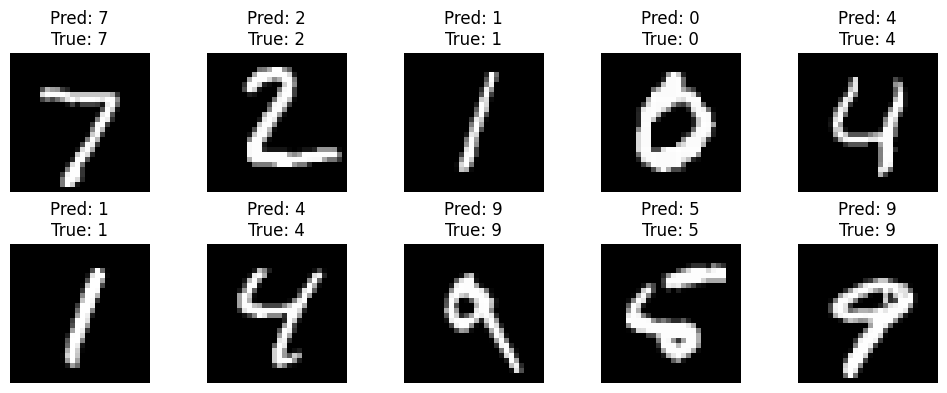

Errors in batch: 1/64


In [8]:
import matplotlib.pyplot as plt

# Get first batch
inputs, labels = next(iter(testloader))
outputs = model(inputs)
_, predicted = torch.max(outputs, 1)

# Plot 10 samples
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for idx in range(10):
    ax = axes[idx//5, idx%5]
    ax.imshow(inputs[idx][0], cmap='gray')
    ax.set_title(f'Pred: {predicted[idx].item()}\nTrue: {labels[idx].item()}')
    ax.axis('off')
plt.tight_layout()
plt.show()

# Count errors
errors = (predicted != labels).sum().item()
print(f'Errors in batch: {errors}/64')